# Plot bins in Rg

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.interpolate as sci
from astropy.io import fits

from gala.units import galactic

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

import tqdm
# from empaf.label_model import VerticalLabelModel
# from empaf.plot import plot_data_models_label_residual

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD THE DATA
# this is the latest APOGEE catalogue that APW sent me with orbital properties determined using StarHorse distances
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 


In [3]:
# load in the mask for the lowalpha disc
lowa = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask.npy',allow_pickle=True)
print(len(data[lowa]))

172656


In [4]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vr = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
# omask = (np.fabs(z)<2*u.kpc)&(np.fabs(vz)<80*u.kpc/u.Gyr)&(np.fabs(deltaR)<3)
omask = (np.abs(z)<2*u.kpc)&(np.abs(vz)<80*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50)
# &(data['ecc']<0.2)
lowa_omask = lowa&omask
# lowa_omask2 = lowa&omask2

print('There are '+str(len(data[lowa]))+' stars in the parent sample')
print('There are '+str(len(data[lowa_omask]))+' stars in the sample we model')


There are 172656 stars in the parent sample
There are 94685 stars in the sample we model


In [5]:
binsss = np.linspace(5,14,9)

bins = []

for indx, i in enumerate(binsss[:-1]):
    mask = (Rg>i)&(Rg<i+2)&omask&lowa&(data['AL_FE']>-10)&(data['MN_FE']>-10)&(data['NI_FE']>-10)&(data['CE_FE']>-10)
    bins.append(mask)

In [6]:
from scipy import stats

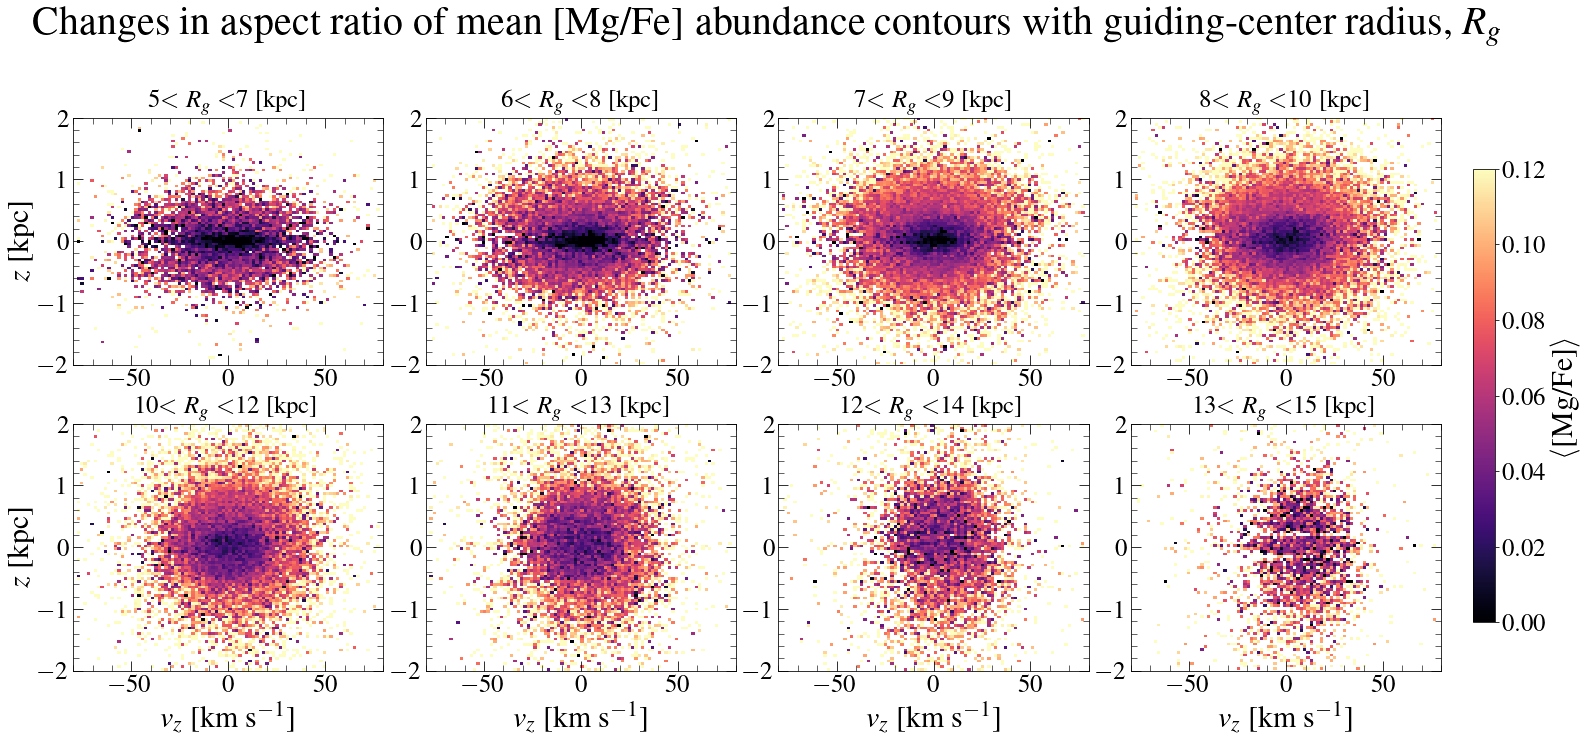

In [7]:
nbins=91
stat='mean'
fig, all_axes = plt.subplots(2,int(len(bins)/2),figsize=(20,9),constrained_layout=True,facecolor='white')
fig.suptitle('Changes in aspect ratio of mean [Mg/Fe] abundance contours with guiding-center radius, $R_{g}$',fontsize=40,x=0.53,y=1.125)
rgs = binsss

for indx, i in enumerate(bins[:len(bins)]):
    plt.subplot(2,int(len(bins)/2),indx+1)
    abun = data['MG_FE']
    plt.title(str(round(binsss[indx]))+r'$<$ $R_{g}$ $<$'+str(round(binsss[indx]+2))+' [kpc]',fontsize=25,pad=10)
    binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)&i]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)&i]),nbins)
    biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)&i]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)&i]),nbins)    
    hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)&i],data['xyz'][:,2][lowa_omask&(abun>-10)&i], abun[lowa_omask&(abun>-10)&i], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=0.0,vmax=0.12,rasterized=True)
#     plt.ylabel('$z$ [kpc]', fontsize=25)
    plt.xlim(-80,80)
    plt.ylim(-2,2)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

cbar_ax = fig.add_axes([1.02, 0.175, 0.015,0.7])
cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


all_axes[0,0].set_ylabel('$z$ [kpc]',fontsize=30)
all_axes[1,0].set_ylabel('$z$ [kpc]',fontsize=30)
for indx, i in enumerate(all_axes[1,:]):
    i.set_xlabel('$v_{z}$ [km s$^{-1}$]', fontsize=30)

fig.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/abundances-rgbinned-mgfe_bone_logg.pdf',dpi=250, bbox_inches = 'tight')

    

In [8]:
cnfe = np.log10(10**(data['C_FE']+data['FE_H']+8.39) + 10**(data['N_FE']+data['FE_H']+7.78)) - np.log10(10.**8.39 + 10.**7.78) - data['FE_H']

In [9]:
delta = 0.5
rgbin = (Rgal>(8.275-delta))&(Rgal<(8.275+delta))&omask&lowa&(data['AL_FE']>-10)&(data['MN_FE']>-10)&(data['NI_FE']>-10)


In [10]:
xfe=np.dstack([data['C_FE'],data['N_FE'],cnfe,data['O_FE'],data['NA_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],\
               data['S_FE'],data['K_FE'],data['CA_FE'],data['TI_FE'],data['V_FE'],data['CR_FE'],\
               data['MN_FE'],data['FE_H'],data['CO_FE'],data['NI_FE'],data['CE_FE']])[0].T

xfe_labels = ['[C/Fe]','[N/Fe]','[(C+N)/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]',\
             '[S/Fe]','[K/Fe]','[Ca/Fe]','[Ti/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]',\
             '[Ni/Fe]','[Ce/Fe]']
vmins = [-0.1,0.1,-0.03,0.,-0.05,0.,0.,-0.02,0.,0.,-0.05,-0.05,-0.15,-0.03,-0.03,-0.3,-0.03,-0.03,-0.4]
vmaxs = [0.05,0.3,0.06,0.1,0.075,0.1,0.1,0.1,0.1,0.1,0.08,0.08,0.05,0.04,0.04,0.3,0.1,0.06,0.05]


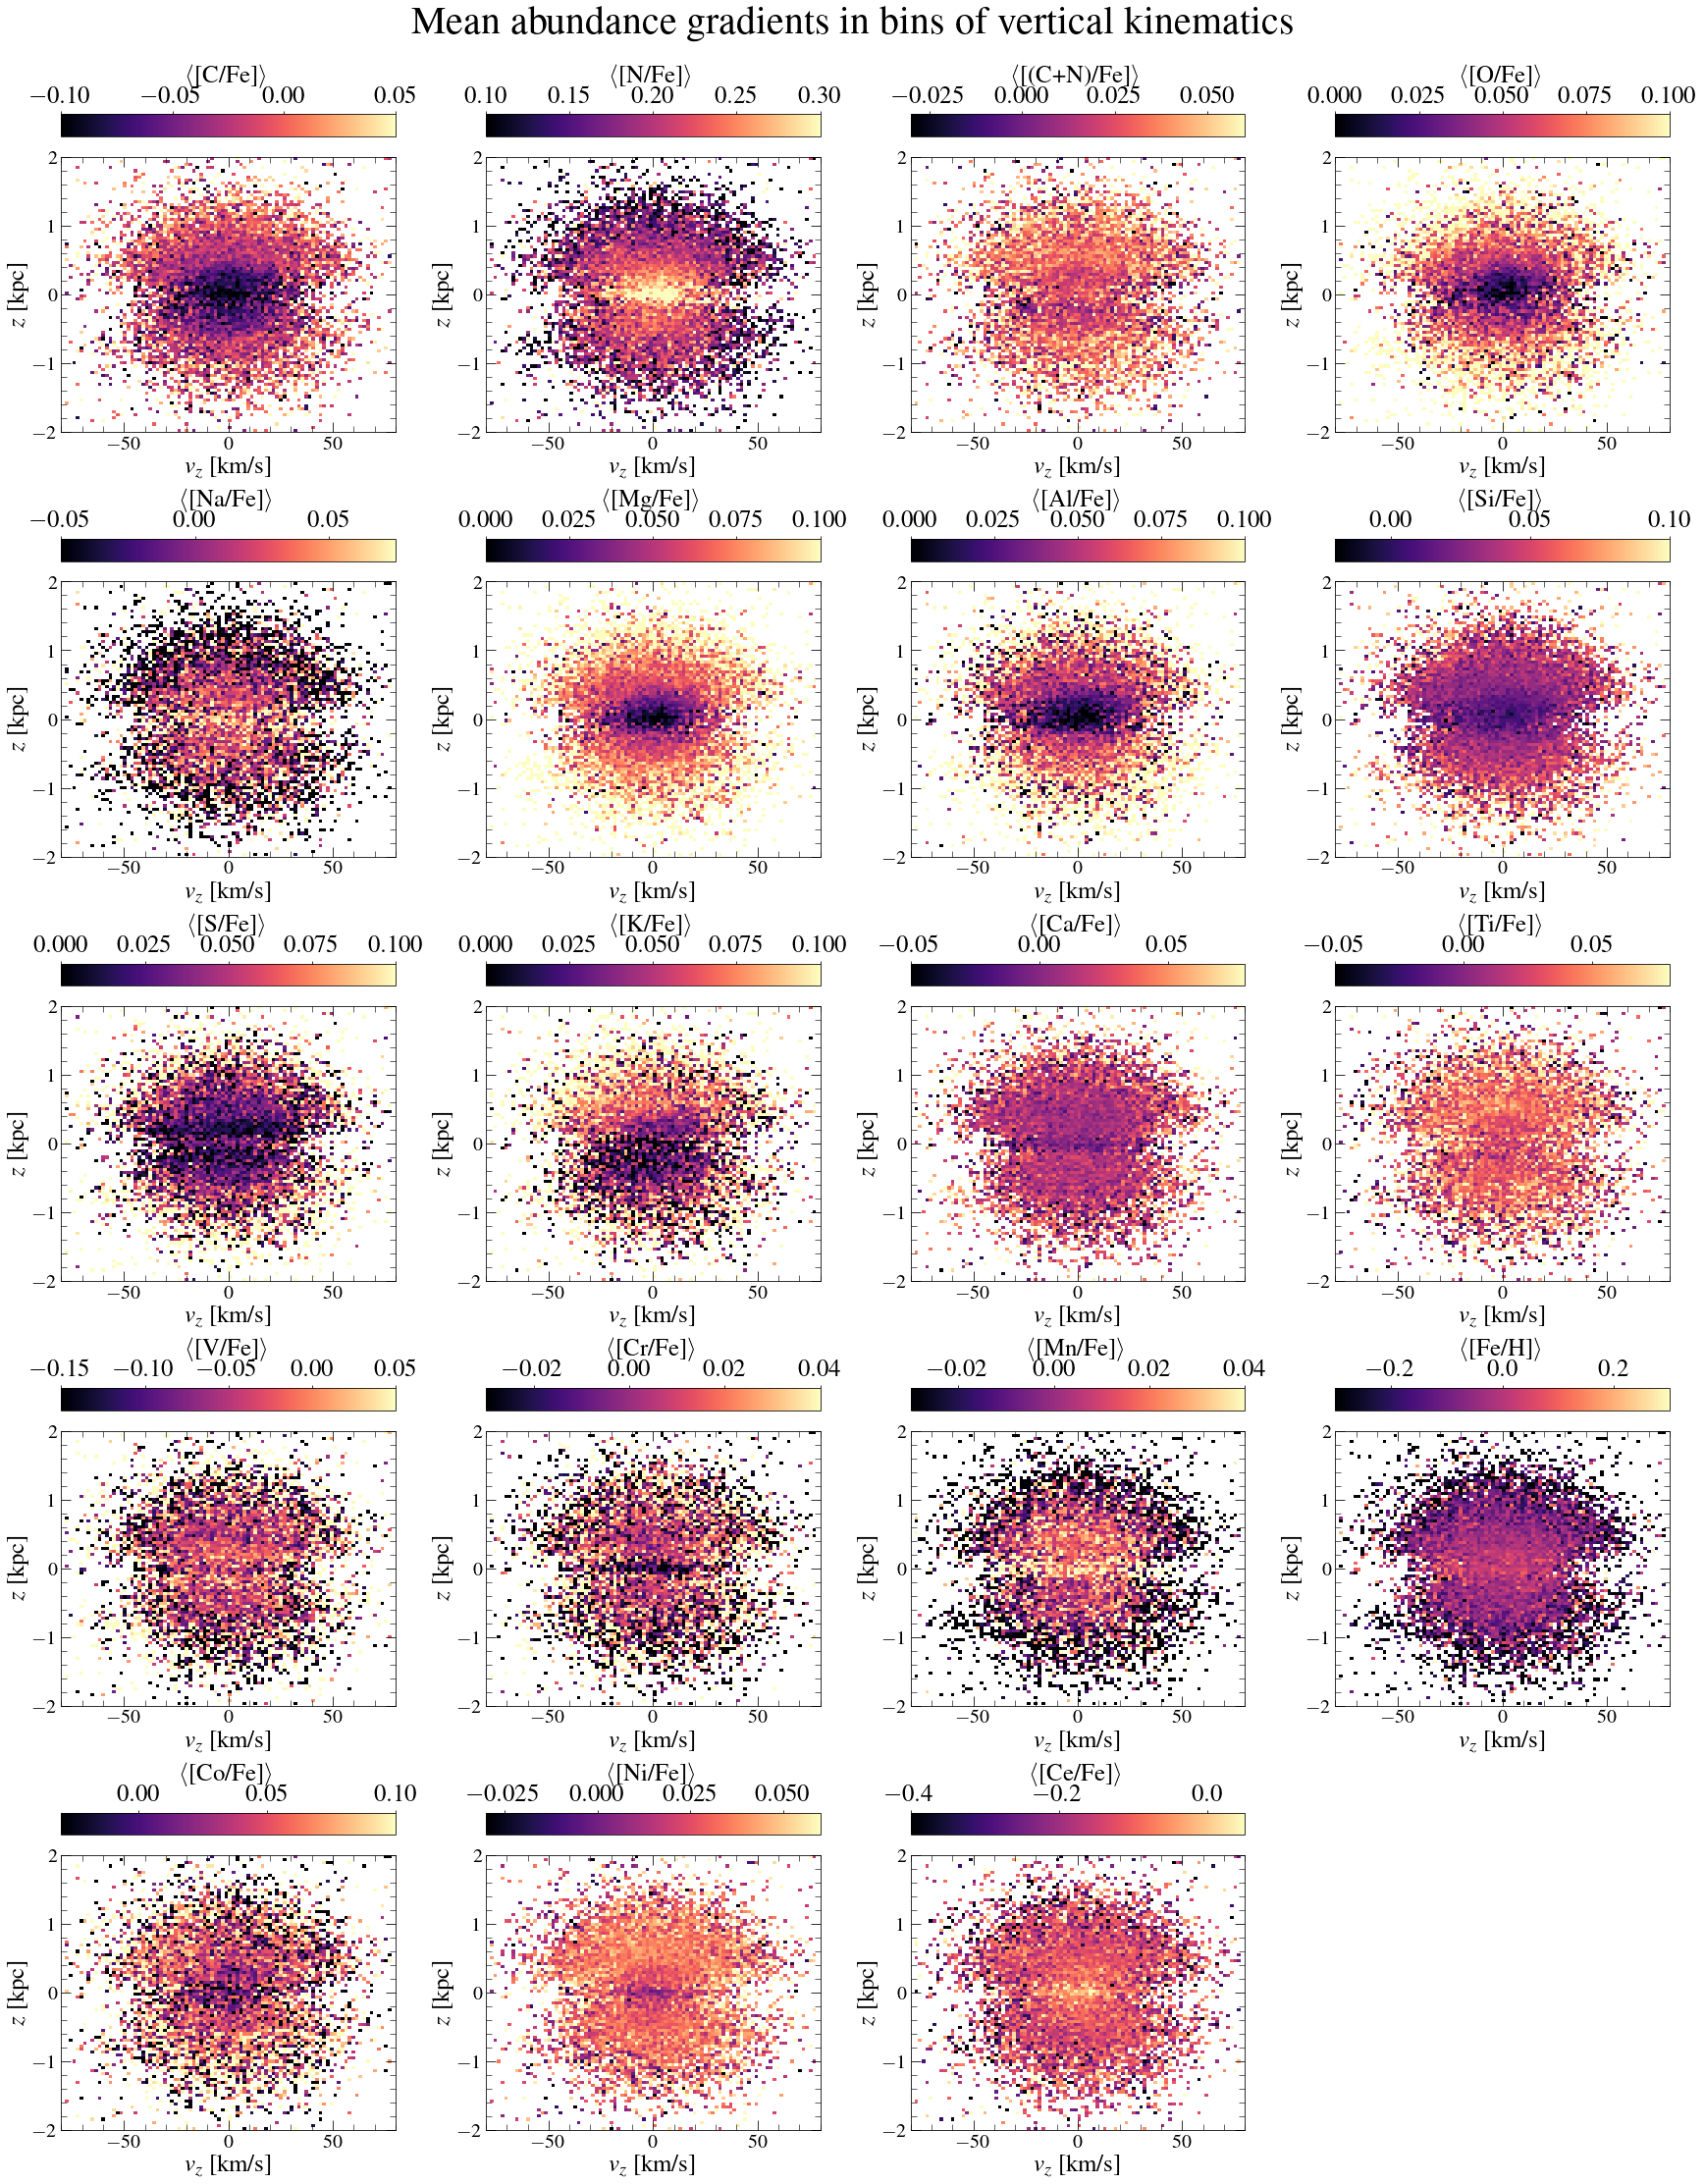

In [11]:

nbins=91
stat='mean'
fig = plt.figure(figsize=(24,30),constrained_layout=True,facecolor='white')
fig.suptitle('Mean abundance gradients in bins of vertical kinematics',fontsize=40,x=0.5,y=1.025)

for indx, i in enumerate(xfe):

    plt.subplot(5,4,indx+1)
    abun = i
    binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)
    biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)    
    hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin],data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin], i[lowa_omask&(abun>-10)&rgbin], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=vmins[indx],vmax=vmaxs[indx],rasterized=True)
    plt.xlabel('$v_{z}$ [km/s]', fontsize=25)
    plt.ylabel('$z$ [kpc]', fontsize=25)
    plt.xlim(-80,80)
    plt.ylim(-2,2)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25)
    cbar.ax.tick_params(labelsize=25)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
fig.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/gradients-all-abundances-total.pdf',dpi=250, bbox_inches = 'tight')


In [13]:
def plot_xfe_spatialbins_zvz(xfe,z,vz,discmask,mask1,mask2,mask3,mask4,mask5,stat='mean',n=10,nbins=91):
    
    fig, all_axes = plt.subplots(6, 5, constrained_layout=True, figsize=(20, 20), rasterized=True)

    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]','[Mg/Fe]']
        vmins = [-0.05,-0.05,-0.1,-0.2,-0.6,0.]
        vmaxs = [0.15,0.05,0.1,0.2,0.2,0.1]
        
        axis[0].set_title(r'6$<R_{g}<$8 [kpc]',fontsize=14)
#         plt.subplot(1,3,1)
        # now create a grid and compute the statistic you want within a given cell
        binx = np.linspace(np.min(z[discmask&mask1&(i>-10)]),np.max(z[discmask&mask1&(i>-10)]),nbins)
        biny = np.linspace(np.min(vz[discmask&mask1&(i>-10)]),np.max(vz[discmask&mask1&(i>-10)]),nbins)    
        hist = stats.binned_statistic_2d(z[discmask&mask1&(i>-10)],vz[discmask&mask1&(i>-10)], i[discmask&mask1&(i>-10)], statistic=stat, bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx,biny)    
        color = axis[0].pcolormesh(plot_x, plot_y, hist[0].T, cmap="magma",vmin=vmins[indx],vmax=vmaxs[indx])
#         plt.aspect('equal')
        
#         plt.subplot(1,3,2)
        axis[1].set_title(r'7$<R_{g}<$9 [kpc]',fontsize=14)
        # now create a grid and compute the statistic you want within a given cell
        binx = np.linspace(np.min(z[discmask&mask2&(i>-10)]),np.max(z[discmask&mask2&(i>-10)]),nbins)
        biny = np.linspace(np.min(vz[discmask&mask2&(i>-10)]),np.max(vz[discmask&mask2&(i>-10)]),nbins)    
        hist = stats.binned_statistic_2d(z[discmask&mask2&(i>-10)],vz[discmask&mask2&(i>-10)], i[discmask&mask2&(i>-10)], statistic=stat, bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx,biny)    
        color = axis[1].pcolormesh(plot_x, plot_y, hist[0].T, cmap="magma",vmin=vmins[indx],vmax=vmaxs[indx])
#         plt.aspect('equal')
        
#         plt.subplot(1,3,3)
        axis[2].set_title(r'8$<R_{g}<$10 [kpc]',fontsize=14)
        # now create a grid and compute the statistic you want within a given cell
        binx = np.linspace(np.min(z[discmask&mask3&(i>-10)]),np.max(z[discmask&mask3&(i>-10)]),nbins)
        biny = np.linspace(np.min(vz[discmask&mask3&(i>-10)]),np.max(vz[discmask&mask3&(i>-10)]),nbins)    
        hist = stats.binned_statistic_2d(z[discmask&mask3&(i>-10)],vz[discmask&mask3&(i>-10)], i[discmask&mask3&(i>-10)], statistic=stat, bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx,biny)    
        color = axis[2].pcolormesh(plot_x, plot_y, hist[0].T, cmap="magma",vmin=vmins[indx],vmax=vmaxs[indx])
        
        axis[3].set_title(r'9$<R_{g}<$11 [kpc]',fontsize=14)
        # now create a grid and compute the statistic you want within a given cell
        binx = np.linspace(np.min(z[discmask&mask4&(i>-10)]),np.max(z[discmask&mask4&(i>-10)]),nbins)
        biny = np.linspace(np.min(vz[discmask&mask4&(i>-10)]),np.max(vz[discmask&mask4&(i>-10)]),nbins)    
        hist = stats.binned_statistic_2d(z[discmask&mask4&(i>-10)],vz[discmask&mask4&(i>-10)], i[discmask&mask4&(i>-10)], statistic=stat, bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx,biny)    
        color = axis[3].pcolormesh(plot_x, plot_y, hist[0].T, cmap="magma",vmin=vmins[indx],vmax=vmaxs[indx])
#         plt.aspect('equal')
        
        axis[4].set_title(r'10$<R_{g}<$12 [kpc]',fontsize=14)
        # now create a grid and compute the statistic you want within a given cell
        binx = np.linspace(np.min(z[discmask&mask5&(i>-10)]),np.max(z[discmask&mask5&(i>-10)]),nbins)
        biny = np.linspace(np.min(vz[discmask&mask5&(i>-10)]),np.max(vz[discmask&mask5&(i>-10)]),nbins)    
        hist = stats.binned_statistic_2d(z[discmask&mask5&(i>-10)],vz[discmask&mask5&(i>-10)], i[discmask&mask5&(i>-10)], statistic=stat, bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx,biny)    
        color = axis[4].pcolormesh(plot_x, plot_y, hist[0].T, cmap="magma",vmin=vmins[indx],vmax=vmaxs[indx])
#         plt.aspect('equal')
    
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        for ax in all_axes[-1]:
            ax.set_xlabel('$v_{z}$ [km/s]',fontsize=25)
        for ax in all_axes[:, 0]:
            ax.set_ylabel('$z$ [kpc]',fontsize=25)
        
        for ax in all_axes[:,0]:
            ax.set_ylim(-2,2)
            ax.set_xlim(-80,80)
        for ax in all_axes[:,1]:
            ax.set_ylim(-2,2)
            ax.set_xlim(-80,80)
        for ax in all_axes[:,2]:
            ax.set_ylim(-2,2)
            ax.set_xlim(-80,80)
        for ax in all_axes[:,3]:
            ax.set_ylim(-2,2)
            ax.set_xlim(-80,80)
        for ax in all_axes[:,4]:
            ax.set_ylim(-2,2)
            ax.set_xlim(-80,80)
            
    fig.patch.set_facecolor('white')
# fig.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/gradients-all-radius.pdf',dpi=600, bbox_inches = 'tight')
    

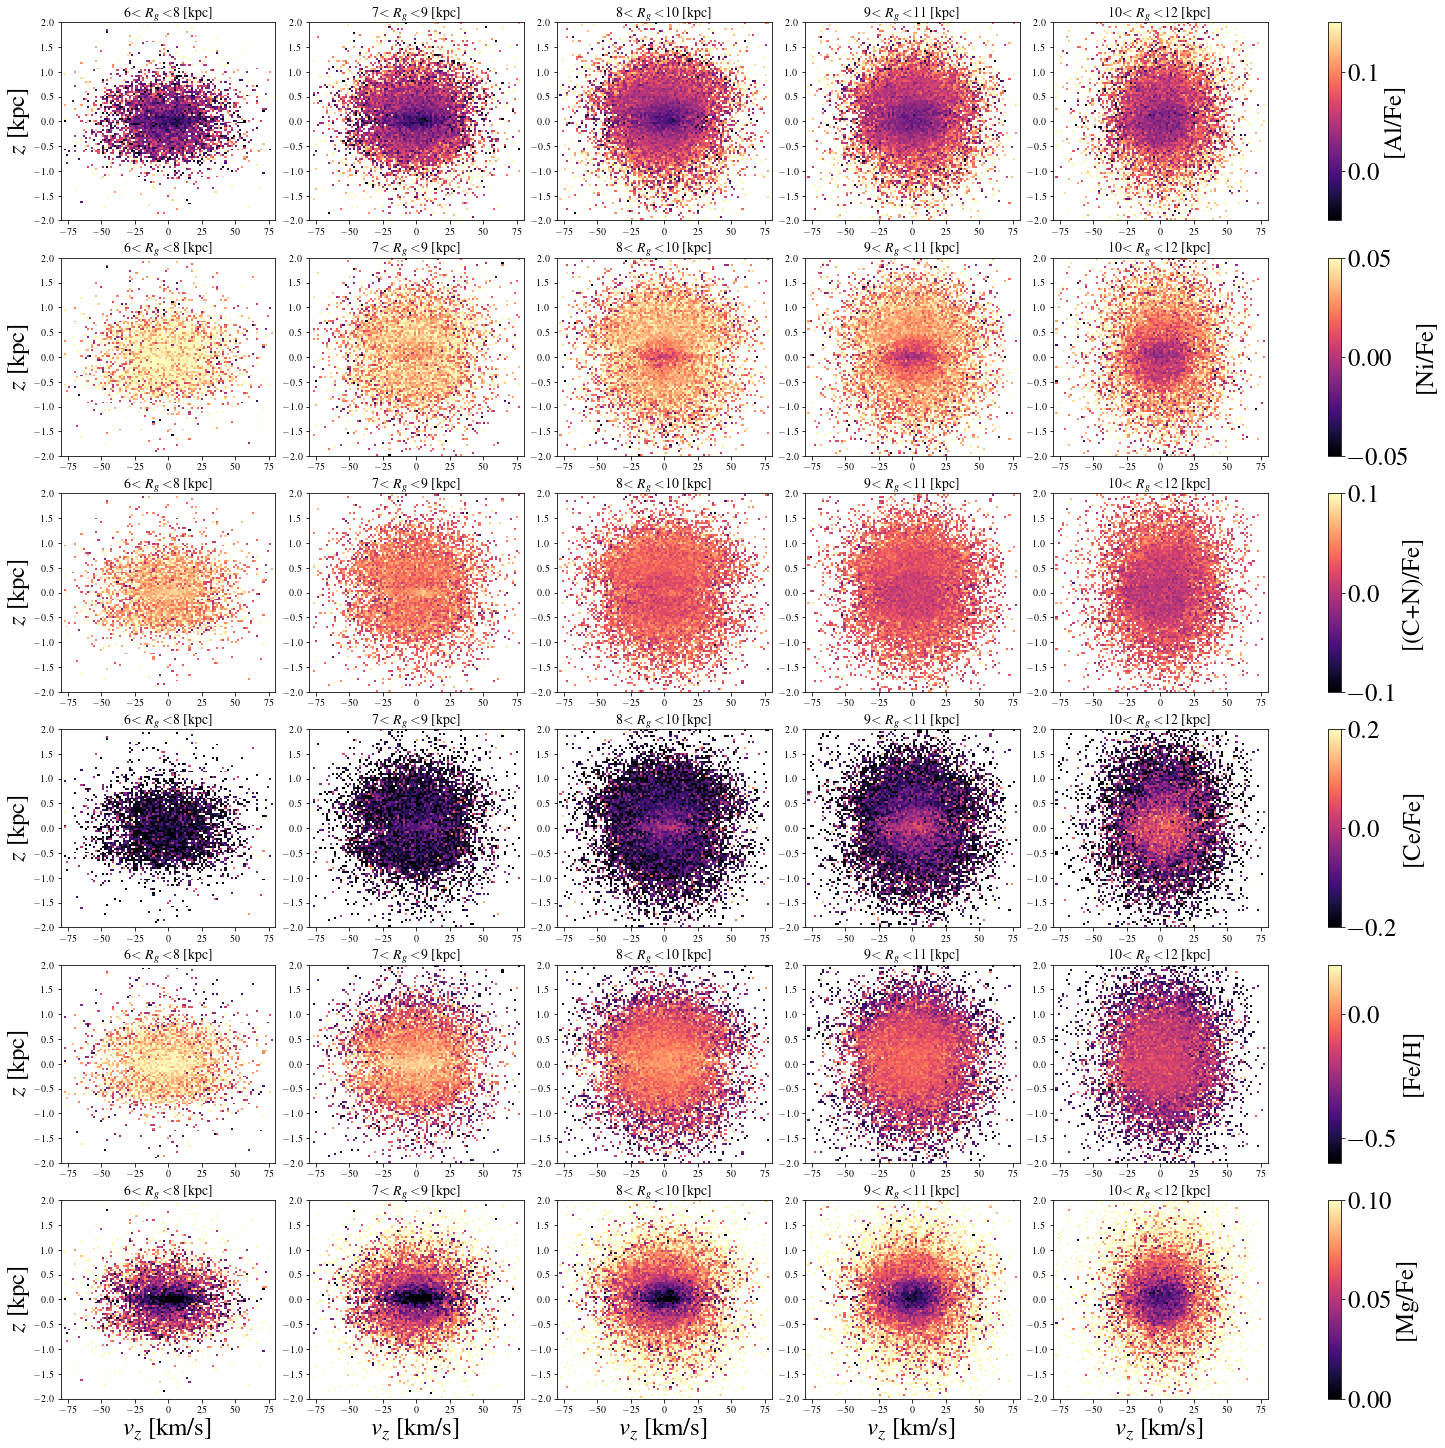

In [14]:
from scipy import stats

z = data['xyz'][:,2]
vz = data['vxyz'][:,2]
# xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T
xfe=np.dstack([data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H'],data['MG_FE']])[0].T

plot_xfe_spatialbins_zvz(xfe,vz,z,lowa_omask,bins[0],bins[1],bins[2],bins[3],bins[4],nbins=100)
